In [1]:
%matplotlib inline
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import os
import glob
import pandas as pd
import numpy as np
import datetime

from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor

from sqlalchemy import select

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

from src.data.processing_func import connect_database
from src.data.load_func import transf_flow_labels

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 500)

In [2]:
%%time

def load_radar_data(start_date, end_date):
    #Iterate over all clean files and keep the ones in desired date range
    all_files = glob.glob(project_dir + "/data/interim/clean/*/*.xlsx")

    desired_files = [file for file in all_files
                     if (datetime.datetime.strptime(file.split("/")[-1].split(".")[0], "%Y-%m-%d").date() >= start_date) and
                        (datetime.datetime.strptime(file.split("/")[-1].split(".")[0], "%Y-%m-%d").date() <= end_date)
                    ]
    df_radar = pd.DataFrame()
    for file in desired_files:
        temp_df = pd.read_excel(file)
        df_radar = df_radar.append(temp_df, ignore_index=True)
    
    return df_radar

df_radar = pd.read_csv(project_dir + "/data/interim/20170305_clean_aggregated_sagemaker.csv",
                         index_col=0,
                         dtype={"Corredor": object,
                                "Ciclofaixa": object,
                                "Numero de faixas": object})
df_radar.reset_index(inplace=True, drop=True)
display(df_radar.shape)
display(df_radar.head()) 

/home/bogo/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(1486080, 22)

,Endereco,Corredor,Ciclofaixa,Numero de faixas,Latitude,Longitude,Sentido,Data,Equipamento,Horario,00 a 10,11 a 20,21 a 30,31 a 40,41 a 50,51 a 60,61 a 70,71 a 80,81 a 90,91 a 100,Acima de 100,Total
0,Rua Areia Branca. 681,0,0,1,-26.26574,-48.80091,L/O,2017-09-01,FS551JOI,00:00 as 00:14,0,1,1,4,8,1,0,0,0,0,0,15
1,Rua Areia Branca. 681,0,0,1,-26.26574,-48.80091,L/O,2017-09-01,FS551JOI,00:15 as 00:29,0,0,1,10,6,0,0,0,0,0,0,17
2,Rua Areia Branca. 681,0,0,1,-26.26574,-48.80091,L/O,2017-09-01,FS551JOI,00:30 as 00:44,0,0,0,1,6,2,0,1,0,0,0,10
3,Rua Areia Branca. 681,0,0,1,-26.26574,-48.80091,L/O,2017-09-01,FS551JOI,00:45 as 00:59,0,0,2,6,6,1,0,0,0,0,0,15
4,Rua Areia Branca. 681,0,0,1,-26.26574,-48.80091,L/O,2017-09-01,FS551JOI,01:00 as 01:14,0,0,0,1,1,0,0,0,0,0,0,2


CPU times: user 8.1 s, sys: 3 s, total: 11.1 s
Wall time: 14.1 s


In [3]:
#Fill na values on manually filled cells
df_radar[["Corredor", "Ciclofaixa", "Numero de faixas"]] = df_radar[["Corredor", "Ciclofaixa", "Numero de faixas"]].replace("-", np.nan)

#Convert date df_radar["Data"], format="%Y-%m-%d"to datetime
df_radar["Data"] = pd.to_datetime(df_radar["Data"], format="%Y-%m-%d")

#Sum flows counted separately in Template 3
df_radar_gb = df_radar.groupby(["Endereco",
                                "Corredor",
                                "Ciclofaixa",
                                "Numero de faixas",
                                "Latitude",
                                "Longitude",
                                "Sentido",
                                "Data",
                                "Equipamento",
                                "Horario",
                               ]).agg('sum')
display(df_radar_gb.shape)
display(df_radar_gb.head())
df_radar_gb.reset_index(inplace=True)

(1440000, 12)

00 a 10  \
Endereco                         Corredor Ciclofaixa Numero de faixas Latitude  Longitude Sentido   Data       Equipamento Horario                   
Av. Aluisio Pires Condeixa. 2700 0        0          2                -26.27918 -48.84623 Sul/Norte 2017-09-01 FS593JOI    00:00 as 00:14        0   
                                                                                                                           00:15 as 00:29        0   
                                                                                                                           00:30 as 00:44        0   
                                                                                                                           00:45 as 00:59        0   
                                                                                                                           01:00 as 01:14        0   

                                                                                                                                           11 a 20  \
Endereco                         Corredor Ciclofaixa Numero de faixas Latitude  Longitude Sentido   Data       Equipamento Horario                   
Av. Aluisio Pires Condeixa. 2700 0        0          2                -26.27918 -48.84623 Sul/Norte 2017-09-01 FS593JOI    00:00 as 00:14        0   
                                                                                                                           00:15 as 00:29        0   
                                                                                                                           00:30 as 00:44        0   
                                                                                                                           00:45 as 00:59        0   
                                                                                                                           01:00 as 01:14        0   

                                                                                                                                           21 a 30  \
Endereco                         Corredor Ciclofaixa Numero de faixas Latitude  Longitude Sentido   Data       Equipamento Horario                   
Av. Aluisio Pires Condeixa. 2700 0        0          2                -26.27918 -48.84623 Sul/Norte 2017-09-01 FS593JOI    00:00 as 00:14        0   
                                                                                                                           00:15 as 00:29        0   
                                                                                                                           00:30 as 00:44        0   
                                                                                                                           00:45 as 00:59        0   
                                                                                                                           01:00 as 01:14        0   

                                                                                                                                           31 a 40  \
Endereco                         Corredor Ciclofaixa Numero de faixas Latitude  Longitude Sentido   Data       Equipamento Horario                   
Av. Aluisio Pires Condeixa. 2700 0        0          2                -26.27918 -48.84623 Sul/Norte 2017-09-01 FS593JOI    00:00 as 00:14        5   
                                                                                                                           00:15 as 00:29        4   
                                                                                                                           00:30 as 00:44        3   
                                                                                                                           00:45 as 00:59        1   
                                                                                      

It is important to remember that slots that show up in the following table can contain 1 or 2 signals from Waze. This may impact the model since it is an indicator of the overall duration of the traffic jam, in that section, during that period.

Remember to include that in the model in a future moment.

In [31]:
project_dir = os.path.join(".", os.pardir, os.pardir)

#Get processed datasets
filenames = glob.glob(project_dir+"/data/test/flow_dataset_*.csv")
filenames.sort()

frame = pd.DataFrame()
list_ = []
for file_ in filenames:
    df = pd.read_csv(file_, index_col=0)
    list_.append(df)
df = pd.concat(list_)
df.reset_index(inplace=True)
df = df[['SctnId', 'Endereco', 'SctnDscNome', 'Direction', 'date', 'hour', 'minute_bin',
         'Velocidade Média (km/h)', 'Atraso médio (s)', 'Fila média (m)', 'Nível médio de congestionamento (0 a 5)', 
         'Numero de faixas', 'Ciclofaixa', 'Corredor','Equipamento',
         '00 a 10', '11 a 20', '21 a 30', '31 a 40', '41 a 50', '51 a 60',
         '61 a 70', '71 a 80', '81 a 90', '91 a 100', 'Acima de 100', 'Total',
        ]]
print(df.shape)
df.sample(5)

(2698, 27)


,SctnId,Endereco,SctnDscNome,Direction,date,hour,minute_bin,Velocidade Média (km/h),Atraso médio (s),Fila média (m),Nível médio de congestionamento (0 a 5),Numero de faixas,Ciclofaixa,Corredor,Equipamento,00 a 10,11 a 20,21 a 30,31 a 40,41 a 50,51 a 60,61 a 70,71 a 80,81 a 90,91 a 100,Acima de 100,Total
2489,7383.0,Av. José Vieira X Rua Itaiópolis,AVENIDA JOSE VIEIRA,South,2017-12-20,14,45 a 59,6.000000,217.333333,454.0,3.666667,2,0,1,FS596JOI,1,119,156,46,2,0,0,0,0,0,0,324
449,5138.0,Rua Fátima. 542,FATIMA,South,2017-10-17,19,0 a 14,16.630000,103.000000,896.0,2.500000,1,0,0,FS640JOI,0,6,12,43,37,4,0,0,0,0,0,102
1089,5138.0,Rua Fátima. 542,FATIMA,South,2017-11-07,19,30 a 44,15.346667,105.666667,984.0,3.000000,1,0,0,FS640JOI,0,0,8,68,25,0,0,0,0,0,0,101
387,5138.0,Rua Fátima. 542,FATIMA,South,2017-10-16,17,0 a 14,19.805000,70.500000,947.0,2.000000,1,0,0,FS640JOI,0,8,10,58,20,0,0,0,0,0,0,96
104,5138.0,Rua Fátima. 542,FATIMA,South,2017-10-07,22,30 a 44,17.290000,87.000000,774.0,2.000000,1,0,0,FS640JOI,0,5,8,30,20,1,0,0,0,0,0,64


Points with zero traffic count (Total) are odd, since they are matched with a traffic jam nearby. Let's remove these.

In [32]:
display(df.shape)
display(df[df["Total"]==0].shape)
df = df.loc[df["Total"]!=0]
display(df.shape)

(2698, 27)

(42, 27)

(2656, 27)

Due to buffer approximations, some radars belong simultaneously to more than one street section with similar traffic indicators. Since there might be a correlation between traffic congestion and traffic flow in subsequent sections, we'll leave all sections in the data set.

In [33]:
multiple_sections = df
multiple_sections = multiple_sections.groupby(["SctnId", "SctnDscNome",
                                               "Equipamento", "Direction"]).agg({"Total": 'mean',
                                                                                "date": 'count'})
multiple_sections.reset_index(inplace=True)
display(multiple_sections.sort_values(["Equipamento", "Total"], ascending=False))

,SctnId,SctnDscNome,Equipamento,Direction,Total,date
4,10496.0,BENJAMIN CONSTANT,FS644JOI,West,157.637255,102
1,5138.0,FATIMA,FS640JOI,South,96.391150,1130
3,8126.0,BLUMENAU,FS633JOI,South,304.875000,112
2,7383.0,AVENIDA JOSE VIEIRA,FS596JOI,South,322.086580,1155
0,937.0,AVENIDA JOSE VIEIRA,FS596JOI,South,306.870968,62
5,15651.0,MONSENHOR GERCINO,FS581JOI,West,117.052632,95


Below we check the relationship between the estimated speed on the section vs the actual speed measured through the radars.

It is clear that, although highly correlated, our estimate of average speed on the section is overly conservative and needs adjustment.

In [51]:
X = df[['Velocidade Média (km/h)', 'Nível médio de congestionamento (0 a 5)', 'Atraso médio (s)',
       'Fila média (m)', 'Numero de faixas', 'Ciclofaixa', 'Corredor']]
y = df['Total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

clf = linear_model.LinearRegression()

clf.fit(X_train,y_train)
print("R2: ", clf.score(X_test, y_test))
display(X.head(), y.head())

R2:  0.833284159278


,Velocidade Média (km/h),Nível médio de congestionamento (0 a 5),Atraso médio (s),Fila média (m),Numero de faixas,Ciclofaixa,Corredor
1,18.62,3.0,70.0,844.0,1,0,0
2,13.04,3.0,91.0,577.0,1,0,0
3,14.89,3.0,63.0,539.0,1,0,0
4,15.16,3.0,61.0,539.0,1,0,0
5,18.72,3.0,76.0,947.0,1,0,0


1    98
2    98
3    92
4    94
5    94
Name: Total, dtype: int64

In [16]:
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train,y_train)
print("R2: ", neigh.score(X_test, y_test))

R2:  0.656482524092


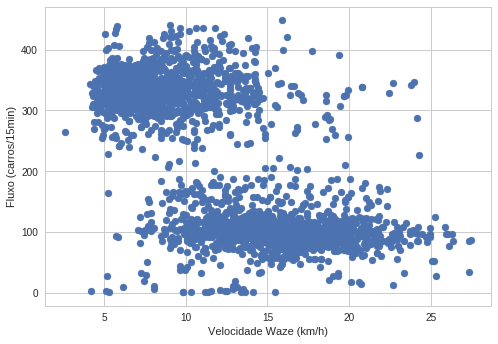

In [52]:
plt.scatter(X['Velocidade Média (km/h)'], y)
plt.xlabel("Velocidade Waze (km/h)")
plt.ylabel("Fluxo (carros/15min)")
plt.show()

17.779086788878821

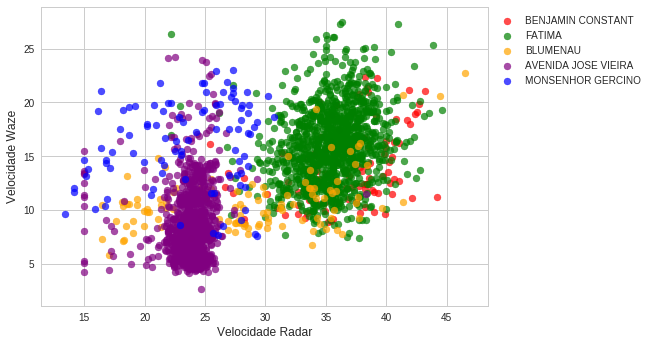

In [38]:
def weighted_average(x, avg_speeds):
    weighted_sum = 0
    for spd in avg_speeds:
        weighted_sum += x[spd]*avg_speeds[spd]
    weighted_avg = weighted_sum/x["Total"]
    
    return weighted_avg

avg_speeds = {"00 a 10": 5,
            "11 a 20": 15,
            "21 a 30": 25,
            "31 a 40": 35,
            "41 a 50": 45,
            "51 a 60": 55,
            "61 a 70": 65,
            "71 a 80": 75,
            "81 a 90": 85,
            "91 a 100": 95,
            "Acima de 100": 105}

df["weighted_avg"] = df.apply(lambda x: weighted_average(x, avg_speeds), axis=1)
df["spd_error"] = (df["Velocidade Média (km/h)"] - df["weighted_avg"])
df["spd_error_sqrd"] = df["spd_error"]**2
display((df["spd_error_sqrd"].sum()/df["spd_error_sqrd"].count())**(1/2))

fig, ax = plt.subplots()

equip_data1 = df[(df["Equipamento"]=="FS644JOI")]
ax.scatter(equip_data1["weighted_avg"],
           equip_data1["Velocidade Média (km/h)"],
           label='BENJAMIN CONSTANT',
           color='red',
           alpha=0.7)

equip_data2 = df[(df["Equipamento"]=="FS640JOI")]
ax.scatter(equip_data2["weighted_avg"],
            equip_data2["Velocidade Média (km/h)"],
            label='FATIMA',
            color='green',
            alpha=0.7)

equip_data3 = df[(df["Equipamento"]=="FS633JOI")]
ax.scatter(equip_data3["weighted_avg"],
            equip_data3["Velocidade Média (km/h)"],
            label='BLUMENAU',
            color='orange',
            alpha=0.7)

equip_data4 = df[(df["Equipamento"]=="FS596JOI") & (df["SctnId"]!=937.0)]
ax.scatter(equip_data4["weighted_avg"],
           equip_data4["Velocidade Média (km/h)"],
           label="AVENIDA JOSE VIEIRA",
           color='purple',
           alpha=0.7)

equip_data5 = df[(df["Equipamento"]=="FS581JOI")]
ax.scatter(equip_data5["weighted_avg"],
           equip_data5["Velocidade Média (km/h)"],
           label="MONSENHOR GERCINO",
           color='blue',
           alpha=0.7)

plt.ylabel("Velocidade Waze", fontsize=12)
plt.xlabel("Velocidade Radar", fontsize=12)
ax.legend(bbox_to_anchor=(1, 1))
sns.set_style("whitegrid")

In [46]:
df["V_squared"] = df['Velocidade Média (km/h)']**2
df["V_cubic"] = df['Velocidade Média (km/h)']**3
X2 = df[['Velocidade Média (km/h)', 'Nível médio de congestionamento (0 a 5)', 'Atraso médio (s)',
       'Fila média (m)', 'Numero de faixas', 'Ciclofaixa', 'Corredor', "V_squared", "V_cubic"]]
y2 = df['Total']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=0)

clf = linear_model.LinearRegression()

clf.fit(X2_train,y2_train)
display(clf.score(X2_test, y2_test))

neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X2_train,y2_train)
display(neigh.score(X2_test, y2_test))




0.83302198060037758

0.61039726445757414